# Support Vector Machines with Diabetes Data

Adapted from Lesmeister (2015) Chapter 5

The data that we will examine was originally collected by the National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK). It consists of 532 observations and eight input features along with a binary outcome (Yes/No). The patients in this study were of Pima Indian descent from South Central Arizona. The NIDDK data shows that since the past 30 years, research has helped scientists to prove that obesity is a major risk factor in the development of diabetes. The Pima Indians were selected for the study as one-half of the adult Pima Indians have diabetes and 95 percent of those with diabetes are overweight. The analysis will focus on adult women only. Diabetes was diagnosed according to the WHO criteria and was of the type of diabetes that is known as type 2. In this type of diabetes, the pancreas is still able to function and produce insulin and it used to be referred to as non-insulin-dependent diabetes.

Our task is to examine and predict those individuals that have diabetes or the risk factors that could lead to diabetes in this population.

## Load libraries and data

In [1]:
library(data.table) # to handle the data in a more convenient manner
library(tidyverse) # for a better work flow and more tools to wrangle and visualize the data
library(plotly) # for interactive visualizations
library(e1071) # for SVM
library(caret) # for model tuning and confusion matrix
library(MASS) # for data
library(kernlab) # for SVM feature selection
library(BBmisc) # data normalization
library(corrplot) # correlation plot

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following ob

In [2]:
data(Pima.tr, package = "MASS")
data(Pima.te, package = "MASS")

There are two separate dataset for train and test

In [3]:
pima_tr_dt <- as.data.table(Pima.tr)
pima_te_dt <- as.data.table(Pima.te)

## Explore dataset

In [4]:
str(pima_tr_dt)

Classes ‘data.table’ and 'data.frame':	200 obs. of  8 variables:
 $ npreg: int  5 7 5 0 0 5 3 1 3 2 ...
 $ glu  : int  86 195 77 165 107 97 83 193 142 128 ...
 $ bp   : int  68 70 82 76 60 76 58 50 80 78 ...
 $ skin : int  28 33 41 43 25 27 31 16 15 37 ...
 $ bmi  : num  30.2 25.1 35.8 47.9 26.4 35.6 34.3 25.9 32.4 43.3 ...
 $ ped  : num  0.364 0.163 0.156 0.259 0.133 ...
 $ age  : int  24 55 35 26 23 52 25 24 63 31 ...
 $ type : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 1 1 1 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [5]:
?Pima.tr

```
These data frames contains the following columns:

npreg
number of pregnancies.

glu
plasma glucose concentration in an oral glucose tolerance test.

bp
diastolic blood pressure (mm Hg).

skin
triceps skin fold thickness (mm).

bmi
body mass index (weight in kg/(height in m)\^2).

ped
diabetes pedigree function.

age
age in years.

type
Yes or No, for diabetic according to WHO criteria.
```

The datasets are contained in the R package, MASS. One data frame is named Pima.tr and the other is named Pima.te. Instead of using these as separate train and test sets, we will combine them and create our own in order to discover how to do such a task in R.

In [6]:
pima <- rbind(pima_tr_dt, pima_te_dt)

In [7]:
str(pima)

Classes ‘data.table’ and 'data.frame':	532 obs. of  8 variables:
 $ npreg: int  5 7 5 0 0 5 3 1 3 2 ...
 $ glu  : int  86 195 77 165 107 97 83 193 142 128 ...
 $ bp   : int  68 70 82 76 60 76 58 50 80 78 ...
 $ skin : int  28 33 41 43 25 27 31 16 15 37 ...
 $ bmi  : num  30.2 25.1 35.8 47.9 26.4 35.6 34.3 25.9 32.4 43.3 ...
 $ ped  : num  0.364 0.163 0.156 0.259 0.133 ...
 $ age  : int  24 55 35 26 23 52 25 24 63 31 ...
 $ type : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 1 1 1 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [8]:
tibble::glimpse(pima)

Observations: 532
Variables: 8
$ npreg <int> 5, 7, 5, 0, 0, 5, 3, 1, 3, 2, 0, 9, 1, 12, 1, 4, 1, 11, 1, 0, 2…
$ glu   <int> 86, 195, 77, 165, 107, 97, 83, 193, 142, 128, 137, 154, 189, 92…
$ bp    <int> 68, 70, 82, 76, 60, 76, 58, 50, 80, 78, 40, 78, 60, 62, 66, 76,…
$ skin  <int> 28, 33, 41, 43, 25, 27, 31, 16, 15, 37, 35, 30, 23, 7, 52, 15, …
$ bmi   <dbl> 30.2, 25.1, 35.8, 47.9, 26.4, 35.6, 34.3, 25.9, 32.4, 43.3, 43.…
$ ped   <dbl> 0.364, 0.163, 0.156, 0.259, 0.133, 0.378, 0.336, 0.655, 0.200, …
$ age   <int> 24, 55, 35, 26, 23, 52, 25, 24, 63, 31, 33, 45, 59, 44, 29, 21,…
$ type  <fct> No, Yes, No, No, No, Yes, No, No, No, Yes, Yes, No, Yes, Yes, N…


In [9]:
pima_melt <- melt(pima, id.var = "type")

Warning message in melt.data.table(pima, id.var = "type"):
“'measure.vars' [npreg, glu, bp, skin, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”

In [10]:
pima_melt

type,variable,value
No,npreg,5
Yes,npreg,7
No,npreg,5
No,npreg,0
No,npreg,0
Yes,npreg,5
No,npreg,3
No,npreg,1
No,npreg,3
Yes,npreg,2


Warning message in melt.data.table(., id.var = "type"):
“'measure.vars' [npreg, glu, bp, skin, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”

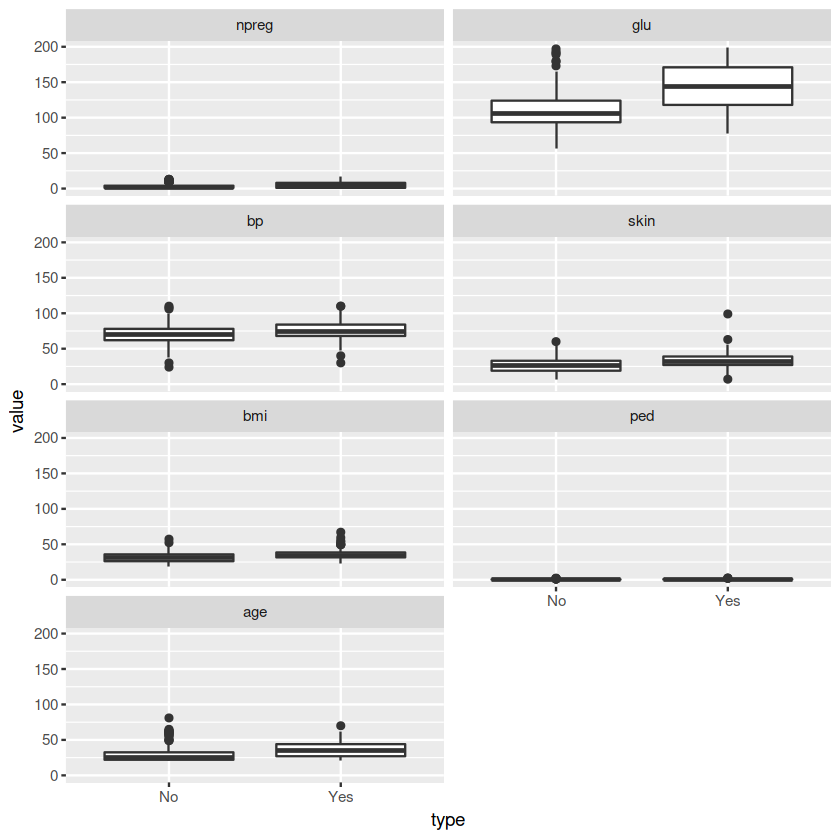

In [11]:
pima %>%
data.table::melt(id.var = "type") %>%
ggplot(aes(x = type, y = value)) +
geom_boxplot() +
facet_wrap(~variable, ncol = 2)

This is an interesting plot because it is difficult to discern any dramatic differences in the plots, probably with the exception of glucose (glu). As you may have suspected, the fasting glucose appears to be significantly higher in the patients currently diagnosed with diabetes. The main problem here is that the plots are all on the same y axis scale. We can fix this and produce a more meaningful plot by standardizing  the values and then re-plotting.

In [12]:
pima_scale <- pima[,cbind(BBmisc::normalize(.SD), type), .SDcols = !"type"]
pima_scale

npreg,glu,bp,skin,bmi,ped,age,type
0.4477858,-1.1300306,-0.28477392,-0.11234745,-0.39095814,-0.4033309,-0.70757816,No
1.0516440,2.3861862,-0.12230772,0.36276259,-1.13211776,-0.9867069,2.17303872,Yes
0.4477858,-1.4203605,0.85248942,1.12293866,0.42286418,-1.0070235,0.31457622,No
-1.0618597,1.4184201,0.36509085,1.31298267,2.18130169,-0.7080796,-0.52173191,No
-1.0618597,-0.4525944,-0.93463868,-0.39741347,-0.94319472,-1.0737779,-0.80050128,No
0.4477858,-0.7751831,0.36509085,-0.20736946,0.39379909,-0.3626978,1.89426934,Yes
-0.1560724,-1.2268072,-1.09710487,0.17271857,0.20487605,-0.4845972,-0.61465503,No
-0.7599306,2.3216684,-1.74696964,-1.25261155,-1.01585743,0.4412581,-0.70757816,No
-0.1560724,0.6764661,0.69002323,-1.34763355,-0.07124223,-0.8793193,2.91642372,No
-0.4580015,0.2248419,0.52755704,0.74285062,1.51280478,2.0927055,-0.05711628,Yes


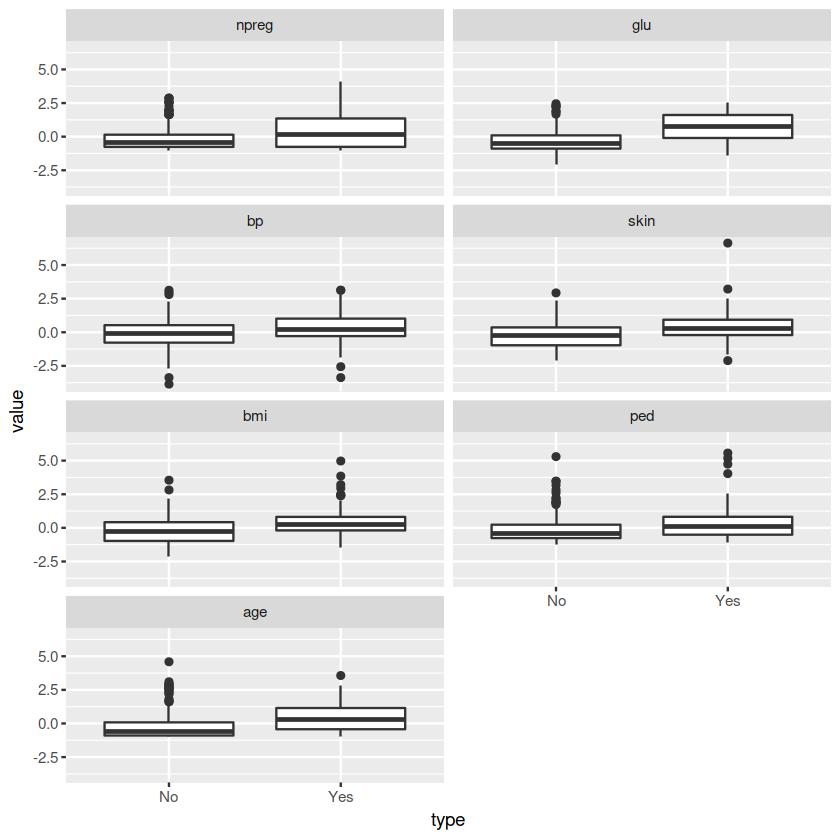

In [13]:
pima_scale %>%
data.table::melt(id.var = "type") %>%
ggplot(aes(x = type, y = value)) +
geom_boxplot() +
facet_wrap(~variable, ncol = 2)

With the features scaled, the plot is easier to read. In addition to glucose, it appear that the other features may differ by type, in particular, age.

Before splitting this into train and test sets, let's have a look at the correlation with the R function, cor(). This will produce a matrix instead of a plot of the Pearson correlations:

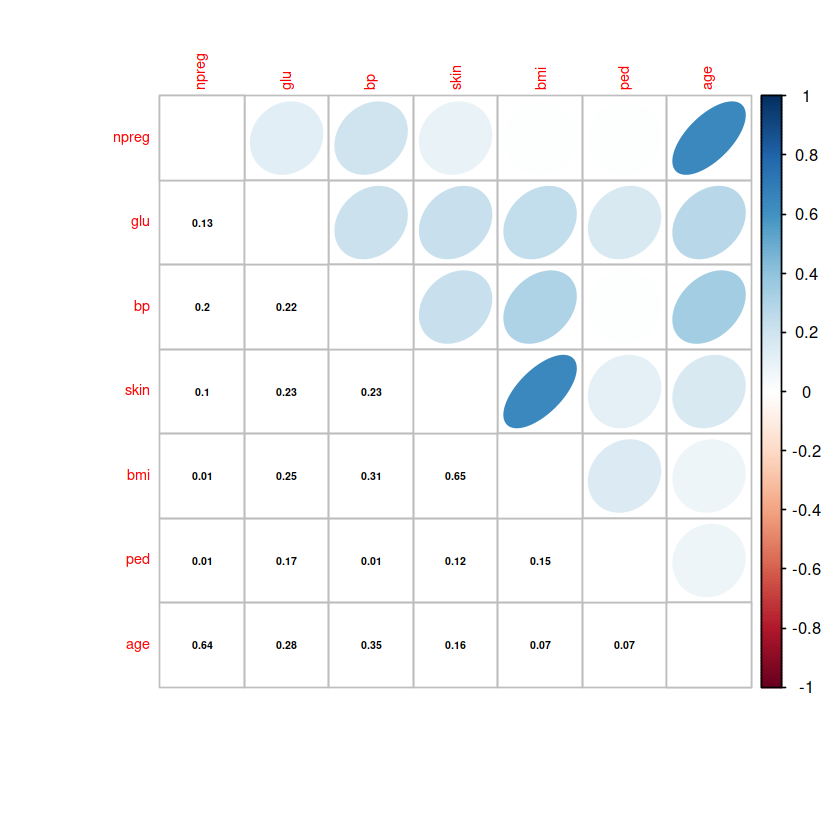

In [14]:
cor(pima_scale[,!"type"]) %>%

corrplot::corrplot.mixed(upper = "ellipse",
                         lower = "number",
                         tl.pos = "lt",
                         number.cex = .5,
                         lower.col = "black",
                         tl.cex = 0.7)

There are a couple of correlations to point out, npreg/age and skin/bmi.  

Multi-collinearity is generally not a problem with these methods, assuming that they are properly trained and the hyperparameters are tuned.

In [15]:
table(pima_scale$type)


 No Yes 
355 177 

## Partitioning the data

In [16]:
set.seed(502)

In [17]:
train <- pima_scale[,sample(.I, 0.7 * .N)]

In [18]:
pima_train <- pima_scale[train]
pima_test <- pima_scale[-train]

## Build and train a model

### Linear model

We will use the e1071 package to build our SVM models. We will start with a linear support vector classifier and then move on to the nonlinear versions. The e1071 package has a nice function for SVM called tune.svm(), which assists in the selection of the tuning parameters/kernel functions.

The tune.svm() function from the package uses cross-validation to optimize the tuning parameters. Let's create an object called linear.tune and call it using the summary() function, as follows:

In [19]:
linear_tune <- e1071::tune.svm(type ~ .,
                               data = pima_train,
                              kernel = "linear",
                              cost = c(0.001, 0.01, 0.1, 1, 5, 10))

What is "cost"?


https://www.quora.com/What-is-the-intuition-behind-the-Cost-and-Gamma-parameters-in-SVM
> C is how much we penalize the SVM for data points within the margin (where "within" can also mean on the wrong side of the dividing hyperplane). Large C means penalize a lot. If your C is large, the SVM will try to find a hyperplane and margin so that there are few very points within the margin, which could mean an overly complex model with a small margin if the points aren't easily separable. A lower C gives higher error on the training set, but finds a larger margin that might be more robust.


In [20]:
summary(linear_tune)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
 0.01

- best performance: 0.2228307 

- Detailed performance results:
   cost     error dispersion
1 1e-03 0.3088193 0.11535153
2 1e-02 0.2228307 0.08720006
3 1e-01 0.2255334 0.09228348
4 1e+00 0.2255334 0.08777595
5 5e+00 0.2255334 0.08777595
6 1e+01 0.2254623 0.09356431


The optimal cost function is one for this data and leads to a misclassification error of roughly 21 percent. We can make predictions on the test data and examine that as  well using the predict() function and applying newdata=test:

In [21]:
best_linear <- linear_tune$best.model

In [22]:
tune_test <- predict(best_linear, newdata = pima_test)

In [23]:
caret::confusionMatrix(tune_test, pima_test$type, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  91  34
       Yes  7  28
                                          
               Accuracy : 0.7438          
                 95% CI : (0.6688, 0.8094)
    No Information Rate : 0.6125          
    P-Value [Acc > NIR] : 0.0003224       
                                          
                  Kappa : 0.4132          
                                          
 Mcnemar's Test P-Value : 4.896e-05       
                                          
            Sensitivity : 0.4516          
            Specificity : 0.9286          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.7280          
             Prevalence : 0.3875          
         Detection Rate : 0.1750          
   Detection Prevalence : 0.2188          
      Balanced Accuracy : 0.6901          
                                          
       'Positive' Class : Yes             
                                 

### Non-linear model

We will now see if non-linear methods will improve our performance and also use cross-validation to select tuning parameters.

#### Polynomial

The first kernel function that we will try is polynomial, and we will be tuning two parameters: a degree of polynomial (degree) and kernel coefficient (coef0). The polynomial order will be 3, 4, and 5 and the coefficient will be in increments from 0.1 to 4, as follows:

In [24]:
set.seed(123)
poly_tune <- e1071::tune.svm(type ~ .,
                            data = pima_train,
                            kernel = "polynomial",
                            degree = 3:5,
                            coef0 = c(0.1, 0.5, 1:4))

In [25]:
summary(poly_tune)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 degree coef0
      3     4

- best performance: 0.2390469 

- Detailed performance results:
   degree coef0     error dispersion
1       3   0.1 0.2471550 0.09110213
2       4   0.1 0.2577525 0.08614050
3       5   0.1 0.2630156 0.08963525
4       3   0.5 0.2497155 0.06952563
5       4   0.5 0.2524182 0.06368959
6       5   0.5 0.2630868 0.08353969
7       3   1.0 0.2524893 0.07350908
8       4   1.0 0.2686344 0.06638899
9       5   1.0 0.2819346 0.07159886
10      3   2.0 0.2416785 0.06478624
11      4   2.0 0.2874111 0.05967660
12      5   2.0 0.2926031 0.08080276
13      3   3.0 0.2443812 0.06664852
14      4   3.0 0.3007824 0.06651282
15      5   3.0 0.2764580 0.08331305
16      3   4.0 0.2390469 0.06191213
17      4   4.0 0.2874822 0.06651649
18      5   4.0 0.2659317 0.05759848


The model has selected degree of 3 for the polynomial and coefficient of 1. 

Just as the linear SVM, we can create predictions on the test set with these parameters, as follows:

In [26]:
best_poly <- poly_tune$best.model

In [27]:
poly_test <- predict(best_poly, newdata = pima_test)

In [28]:
caret::confusionMatrix(poly_test, pima_test$type, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  80  24
       Yes 18  38
                                          
               Accuracy : 0.7375          
                 95% CI : (0.6622, 0.8038)
    No Information Rate : 0.6125          
    P-Value [Acc > NIR] : 0.0005985       
                                          
                  Kappa : 0.437           
                                          
 Mcnemar's Test P-Value : 0.4404007       
                                          
            Sensitivity : 0.6129          
            Specificity : 0.8163          
         Pos Pred Value : 0.6786          
         Neg Pred Value : 0.7692          
             Prevalence : 0.3875          
         Detection Rate : 0.2375          
   Detection Prevalence : 0.3500          
      Balanced Accuracy : 0.7146          
                                          
       'Positive' Class : Yes             
                                 

This did not perform quite as well as the linear model.

#### Radial

We will now run the radial basis function. In this instance, the one parameter that we will solve for is gamma, which we will examine in increments of 0.1 to 4. If gamma is too small, the model will not capture the complexity of the decision boundary; if it is too large, the model will severely overfit:

In [29]:
set.seed(123)
rbf_tune <- e1071::tune.svm(type ~ .,
                           data = pima_train,
                           kernel = "radial",
                           gamma = c(0.1, 0.5, 1:4))

https://www.quora.com/What-is-the-intuition-behind-the-Cost-and-Gamma-parameters-in-SVM

>Gamma is not technically an SVM hyperparameter. It is a parameter of the kernel. In the RBF kernel, it adjusts how similar two points must be to be considered "similar". You can think of the RBF kernel as constructing a hypersphere around each point, whose density is described by a Gaussian function. The value that the kernel generates for points (a, b) is the density of a's hypersphere at point b. Gamma controls the standard deviation of the Gaussian function. Larger gamma means smaller standard deviation around each point.

In [30]:
summary(rbf_tune)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 gamma
   0.1

- best performance: 0.2199858 

- Detailed performance results:
  gamma     error dispersion
1   0.1 0.2199858 0.07292183
2   0.5 0.2335704 0.08031017
3   1.0 0.3011380 0.07199420
4   2.0 0.3147226 0.06950525
5   3.0 0.3120910 0.08162537
6   4.0 0.3093883 0.07754338


The best gamma value is 0.1 and the performance at this setting does not seem to improve much over the other SVM models. We will check for the test set as well in the following way:

In [31]:
best_rbf <- rbf_tune$best.model

In [32]:
rbf_test <- predict(best_rbf, newdata = pima_test)

In [33]:
caret::confusionMatrix(rbf_test, pima_test$type, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  88  28
       Yes 10  34
                                          
               Accuracy : 0.7625          
                 95% CI : (0.6889, 0.8261)
    No Information Rate : 0.6125          
    P-Value [Acc > NIR] : 4.177e-05       
                                          
                  Kappa : 0.4715          
                                          
 Mcnemar's Test P-Value : 0.00582         
                                          
            Sensitivity : 0.5484          
            Specificity : 0.8980          
         Pos Pred Value : 0.7727          
         Neg Pred Value : 0.7586          
             Prevalence : 0.3875          
         Detection Rate : 0.2125          
   Detection Prevalence : 0.2750          
      Balanced Accuracy : 0.7232          
                                          
       'Positive' Class : Yes             
                                 

The performance is downright abysmal.

#### Sigmoid

One last shot to improve here would be with kernel="sigmoid". We will be solving for two parameters that are gamma and the kernel coefficient (coef0)

In [34]:
set.seed(123)
sigmoid_tune <- e1071::tune.svm(type ~ .,
                               data = pima_train,
                               kernel = "sigmoid",
                               gamma = c(0.1, 0.5, 1:4),
                               coef0 = c(0.1, 0.5, 1:4))

In [35]:
summary(sigmoid_tune)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 gamma coef0
   0.1   0.1

- best performance: 0.2227596 

- Detailed performance results:
   gamma coef0     error dispersion
1    0.1   0.1 0.2227596 0.06414278
2    0.5   0.1 0.3222617 0.08630233
3    1.0   0.1 0.3625889 0.08568948
4    2.0   0.1 0.3733997 0.08093676
5    3.0   0.1 0.3679943 0.08235982
6    4.0   0.1 0.3707681 0.06647360
7    0.1   0.5 0.2413940 0.08674584
8    0.5   0.5 0.3274538 0.08875961
9    1.0   0.5 0.3571835 0.08423340
10   2.0   0.5 0.3253912 0.07181210
11   3.0   0.5 0.3464438 0.07868061
12   4.0   0.5 0.3599573 0.07461214
13   0.1   1.0 0.2415363 0.08254660
14   0.5   1.0 0.2952347 0.07762484
15   1.0   1.0 0.3279516 0.07912796
16   2.0   1.0 0.3546942 0.07385163
17   3.0   1.0 0.3545519 0.07422453
18   4.0   1.0 0.3491465 0.07181148
19   0.1   2.0 0.2524893 0.06655552
20   0.5   2.0 0.3300853 0.11219054
21   1.0   2.0 0.3276671 0.08931944
22   2.0   2.0 0.319914

This error rate is in line with the linear model. It is now just a matter of whether it performs better on the test set or not:

In [36]:
best_sigmoid <- sigmoid_tune$best.model

In [37]:
sigmoid_test <- predict(best_sigmoid, newdata = pima_test)

In [38]:
caret::confusionMatrix(sigmoid_test, pima_test$type, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  82  27
       Yes 16  35
                                          
               Accuracy : 0.7312          
                 95% CI : (0.6555, 0.7982)
    No Information Rate : 0.6125          
    P-Value [Acc > NIR] : 0.001078        
                                          
                  Kappa : 0.4148          
                                          
 Mcnemar's Test P-Value : 0.127263        
                                          
            Sensitivity : 0.5645          
            Specificity : 0.8367          
         Pos Pred Value : 0.6863          
         Neg Pred Value : 0.7523          
             Prevalence : 0.3875          
         Detection Rate : 0.2188          
   Detection Prevalence : 0.3187          
      Balanced Accuracy : 0.7006          
                                          
       'Positive' Class : Yes             
                                 

Lo and behold! We finally have a test performance that is in line with the performance on the train data. It appears that we can choose the sigmoid  kernel as the best predictor.

So far we played around with different models. Now, let's evaluate their performance along with the linear model using metrics other than just the accuracy.

The function produces some items that we already covered such as Accuracy and 
Kappa. Here are the other stats that it produces:

- No Information Rate is the proportion of the largest class—63 percent did not have diabetes.
- P-Value is used to test the hypothesis that the accuracy is actually better than No Information Rate.
- We will not concern ourselves with Mcnemar's Test, which is used for the analysis of the matched pairs, primarily in epidemiology studies
- Sensitivity is the true positive rate; in this case, the rate of those not having diabetes has been correctly identified as such.
- Specificity is the true negative rate or, for our purposes, the rate of a diabetic that has been correctly identified.
- The positive predictive value (Pos Pred Value) is the probability of someone in the population classified as being diabetic and truly has the disease. The following formula is used:
- The negative predictive value (Neg Pred Value) is the probability of someone in the population classified as not being diabetic and truly does not have the disease. The formula for this is as follows:
- Prevalence is the estimated population prevalence of the disease, calculated here as the total of the second column (the Yes column) divided by the  total observations.
- Detection Rate is the rate of the true positives that have been identified—in our case, 35—divided by the total observations.
- Detection Prevalence is the predicted prevalence rate, or in our case, the bottom row divided by the total observations.
- Balanced Accuracy is the average accuracy obtained from either class.  This measure accounts for a potential bias in the classifier algorithm,  thus potentially overpredicting the most frequent class. This is simply Sensitivity + Specificity divided by 2.

## Feature selection

All is not lost on feature selection and we want to take some space to show you a quick way in how to begin exploring this matter. It will require some trial and error on your part.

Again, the caret package helps out in this matter as it will run a cross-validation on a linear SVM based on the kernlab package.

To do this, we will need to set the random seed, specify the cross-validation method in the caret's rfeControl() function, perform a recursive feature selection with the rfe() function, and then test how the model performs on the test set.

In rfeControl(), you will need to specify the function based on the model being used. There are several different functions that you can use. Here we will need lrFuncs. To see a list of the available functions, your best bet is to explore the documentation with ?rfeControl and ?caretFuncs. The code for this example is as follows:

In [39]:
set.seed(123)
rfeCNTL <- caret::rfeControl(functions = lrFuncs,
                            method = "cv",
                            number = 10)

In [40]:
svm_features <- caret::rfe(pima_train[,1:7],
                           pima_train[,type],
                          sizes = 7:4,
                          rfeControl = rfeCNTL,
                          method = "svmLinear")

To create the svm_features object, it was important to specify the inputs and response factor, number of input features via sizes, and linear method from kernlab, which is the svmLinear syntax. Other options are available using this method, such as svmPoly. No method for a sigmoid kernel is available. Calling the object allows us to see how the various feature sizes perform, as follows:

In [41]:
svm_features


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         4   0.7793 0.4577    0.07758  0.1909         
         5   0.7765 0.4451    0.08016  0.2016         
         6   0.7900 0.4863    0.07085  0.1724        *
         7   0.7819 0.4616    0.08148  0.1971         

The top 5 variables (out of 6):
   glu, age, ped, bmi, skin


Counter-intuitive as it is, the four variables perform quite well by themselves as well as when skin and bp are included.

Let's try this out on the test set, remembering that the accuracy in the full model was 78 percent:

In [42]:
formula5 <- reformulate(svm_features$optVariables, "type")

In [43]:
svm_5 <- e1071::svm(formula5,
                   data = pima_train,
                   kernel = "linear")

In [44]:
svm_5_predict <- predict(svm_5,
                        newdata = pima_test)

In [45]:
caret::confusionMatrix(svm_5_predict, pima_test$type, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  87  29
       Yes 11  33
                                         
               Accuracy : 0.75           
                 95% CI : (0.6755, 0.815)
    No Information Rate : 0.6125         
    P-Value [Acc > NIR] : 0.0001684      
                                         
                  Kappa : 0.4437         
                                         
 Mcnemar's Test P-Value : 0.0071895      
                                         
            Sensitivity : 0.5323         
            Specificity : 0.8878         
         Pos Pred Value : 0.7500         
         Neg Pred Value : 0.7500         
             Prevalence : 0.3875         
         Detection Rate : 0.2062         
   Detection Prevalence : 0.2750         
      Balanced Accuracy : 0.7100         
                                         
       'Positive' Class : Yes            
                                         

This did not perform as well and we can stick with the full model. You can see through trial and error how this technique can play in order to determine some simple identification of feature importance.